# Long-Term Advertising Effects: An Honest Assessment

## ⚠️ Read This First

**From Charlie:**

There is so much noise in marketing data that, by experience, I know it is almost impossible to measure the long-term effect. Signals over time are drowned in the noise, and all channels' adstock end up being highly correlated.

This notebook shows:
1. One approach that's definitely wrong (dual-adstock with high retention)
2. Some approaches that are less wrong (but still imperfect)
3. Why this problem is fundamentally hard

Based on: **Cain, P.M. (2025). "Long-term advertising effects: The Adstock illusion."**

---

In [1]:
!wget -O long_term_measurement.py https://raw.githubusercontent.com/growthdynamics/shared_assets/main/longterm_effects/PCain_adstock_illusion/long_term_measurement.py


--2026-01-15 16:33:17--  https://raw.githubusercontent.com/growthdynamics/shared_assets/main/longterm_effects/PCain_adstock_illusion/long_term_measurement.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33507 (33K) [text/plain]
Saving to: ‘long_term_measurement.py’

long_term_measureme 100%[===================>]  32.72K  --.-KB/s    in 0.004s  

2026-01-15 16:33:17 (7.44 MB/s) - ‘long_term_measurement.py’ saved [33507/33507]



In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!wget -O long_term_measurement.py https://raw.githubusercontent.com/growthdynamics/shared_assets/main/longterm_effects/PCain_adstock_illusion/long_term_measurement.py

from long_term_measurement import (
    # Data generation
    simulate_marketing_data,

    # Dual-adstock (the problem)
    fit_dual_adstock_model,
    plot_diagnostic_dashboard,
    check_dual_adstock_diagnostics,

    # Alternatives
    fit_ucm_model,
    plot_ucm_decomposition,
    fit_var_model,
    plot_var_irf,
    fit_combined_approach
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

--2026-01-15 16:33:19--  https://raw.githubusercontent.com/growthdynamics/shared_assets/main/longterm_effects/PCain_adstock_illusion/long_term_measurement.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33507 (33K) [text/plain]
Saving to: ‘long_term_measurement.py’

long_term_measureme 100%[===================>]  32.72K  --.-KB/s    in 0s      

2026-01-15 16:33:19 (119 MB/s) - ‘long_term_measurement.py’ saved [33507/33507]



## Part 1: The Problem - Dual-Adstock Spurious Regression

We'll create data where we KNOW there's NO long-term effect, then show how dual-adstock finds one anyway.

In [3]:
# Generate data with NO long-term effects
data = simulate_marketing_data(
    n_periods=156,  # 3 years weekly
    has_true_long_term=False,  # KEY: No long-term effects!
    seed=42
)

print("Ground Truth:")
print("  • TV causes short-term activation only")
print("  • Base sales drift randomly (NOT driven by TV)")
print("  • Therefore: NO long-term TV effects exist")
print()
print("Now let's see what dual-adstock claims...\n")

Ground Truth:
  • TV causes short-term activation only
  • Base sales drift randomly (NOT driven by TV)
  • Therefore: NO long-term TV effects exist

Now let's see what dual-adstock claims...



In [4]:
# Fit dual-adstock model
print("="*70)
print("FITTING DUAL-ADSTOCK MODEL")
print("="*70)

results = fit_dual_adstock_model(
    sales=data['sales'].values,
    tv=data['tv'].values,
    short_retention=0.30,
    long_retention=0.99
)

print(f"\nR² = {results['r2']:.4f}")
print(f"Short-term coefficient = {results['coefficients']['tv_short']:.4f}")
print(f"Long-term coefficient = {results['coefficients']['tv_long']:.4f}")
print(f"\n⚠️  DIAGNOSTICS:")
print(f"Durbin-Watson = {results['dw_statistic']:.4f} (should be ~2.0)")
print(f"Ljung-Box p-value = {results['ljung_box_pvalue']:.6f} (should be >0.05)")

if results['is_spurious']:
    print("\n" + "="*70)
    print("❌ SPURIOUS REGRESSION DETECTED")
    print("="*70)
    print("\nThe model 'finds' a long-term effect that DOES NOT EXIST.")
    print("This is the Adstock Illusion that Cain exposes.")

FITTING DUAL-ADSTOCK MODEL

R² = 0.6891
Short-term coefficient = 0.7897
Long-term coefficient = 0.0890

⚠️  DIAGNOSTICS:
Durbin-Watson = 0.2088 (should be ~2.0)
Ljung-Box p-value = 0.000000 (should be >0.05)

❌ SPURIOUS REGRESSION DETECTED

The model 'finds' a long-term effect that DOES NOT EXIST.
This is the Adstock Illusion that Cain exposes.


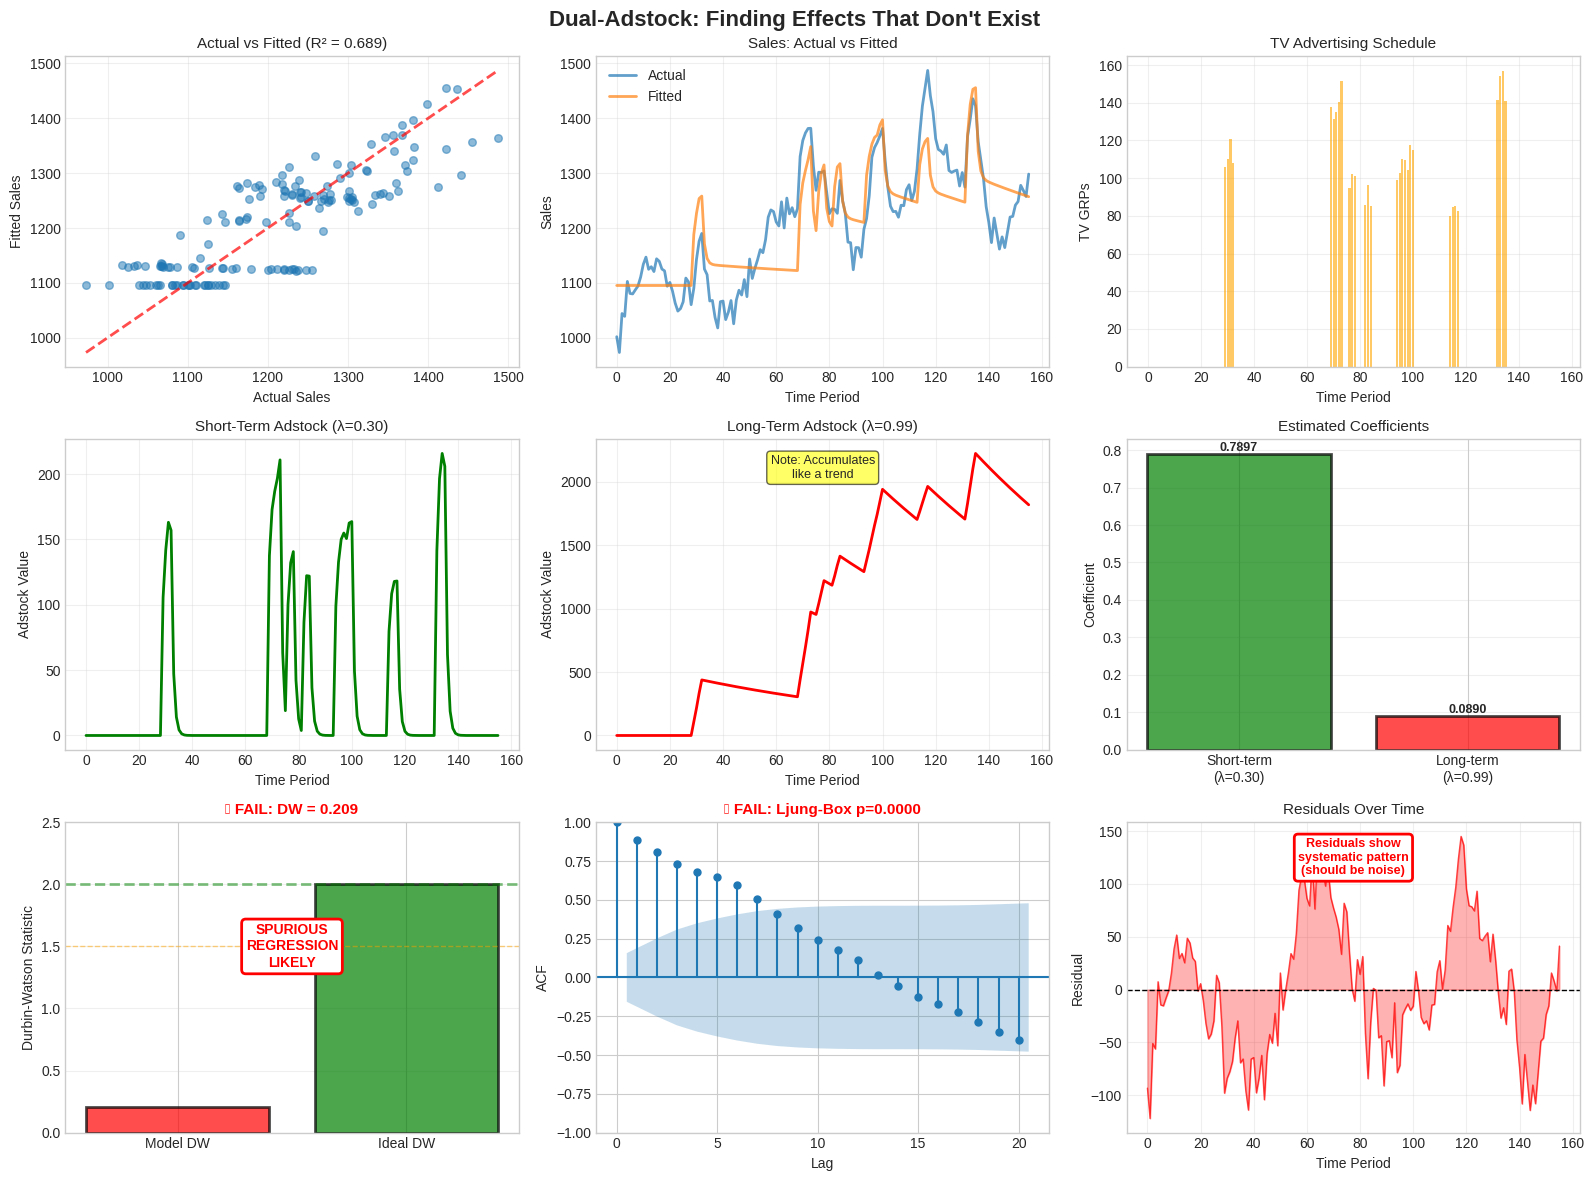


🔍 Look at Row 3 (bottom): Diagnostics reveal the problem!
   • DW catastrophically low
   • ACF shows massive autocorrelation
   • Residuals show clear patterns


In [5]:
# Full diagnostic dashboard
fig = plot_diagnostic_dashboard(
    sales=data['sales'].values,
    tv=data['tv'].values,
    results=results,
    title="Dual-Adstock: Finding Effects That Don't Exist"
)
plt.show()

print("\n🔍 Look at Row 3 (bottom): Diagnostics reveal the problem!")
print("   • DW catastrophically low")
print("   • ACF shows massive autocorrelation")
print("   • Residuals show clear patterns")

## Part 2: Alternative 1 - Unobserved Components Model (UCM)

**What it does:** Explicitly separates stochastic trend from transitory effects.

**Limitations:**
- Sensitive to model specification
- No consensus on implementation
- Still assumes clean separation

**Verdict:** Better than dual-adstock, but not perfect.

In [6]:
print("="*70)
print("FITTING UNOBSERVED COMPONENTS MODEL (UCM)")
print("="*70)

ucm_results = fit_ucm_model(
    sales=data['sales'].values,
    tv=data['tv'].values,
    short_retention=0.30
)

print(f"\nMethod: {ucm_results['method']}")
print(f"R² = {ucm_results['r2']:.4f}")
print(f"Ljung-Box p-value = {ucm_results['ljung_box_pvalue']:.4f}")

if ucm_results['success']:
    print("\n✓ Kalman filter converged")
else:
    print("\n⚠️  Kalman filter failed, used smoothing fallback")
    print("   (This is common - UCM can be finicky)")

FITTING UNOBSERVED COMPONENTS MODEL (UCM)

Method: Kalman filter
R² = 0.4248
Ljung-Box p-value = 0.9992

✓ Kalman filter converged


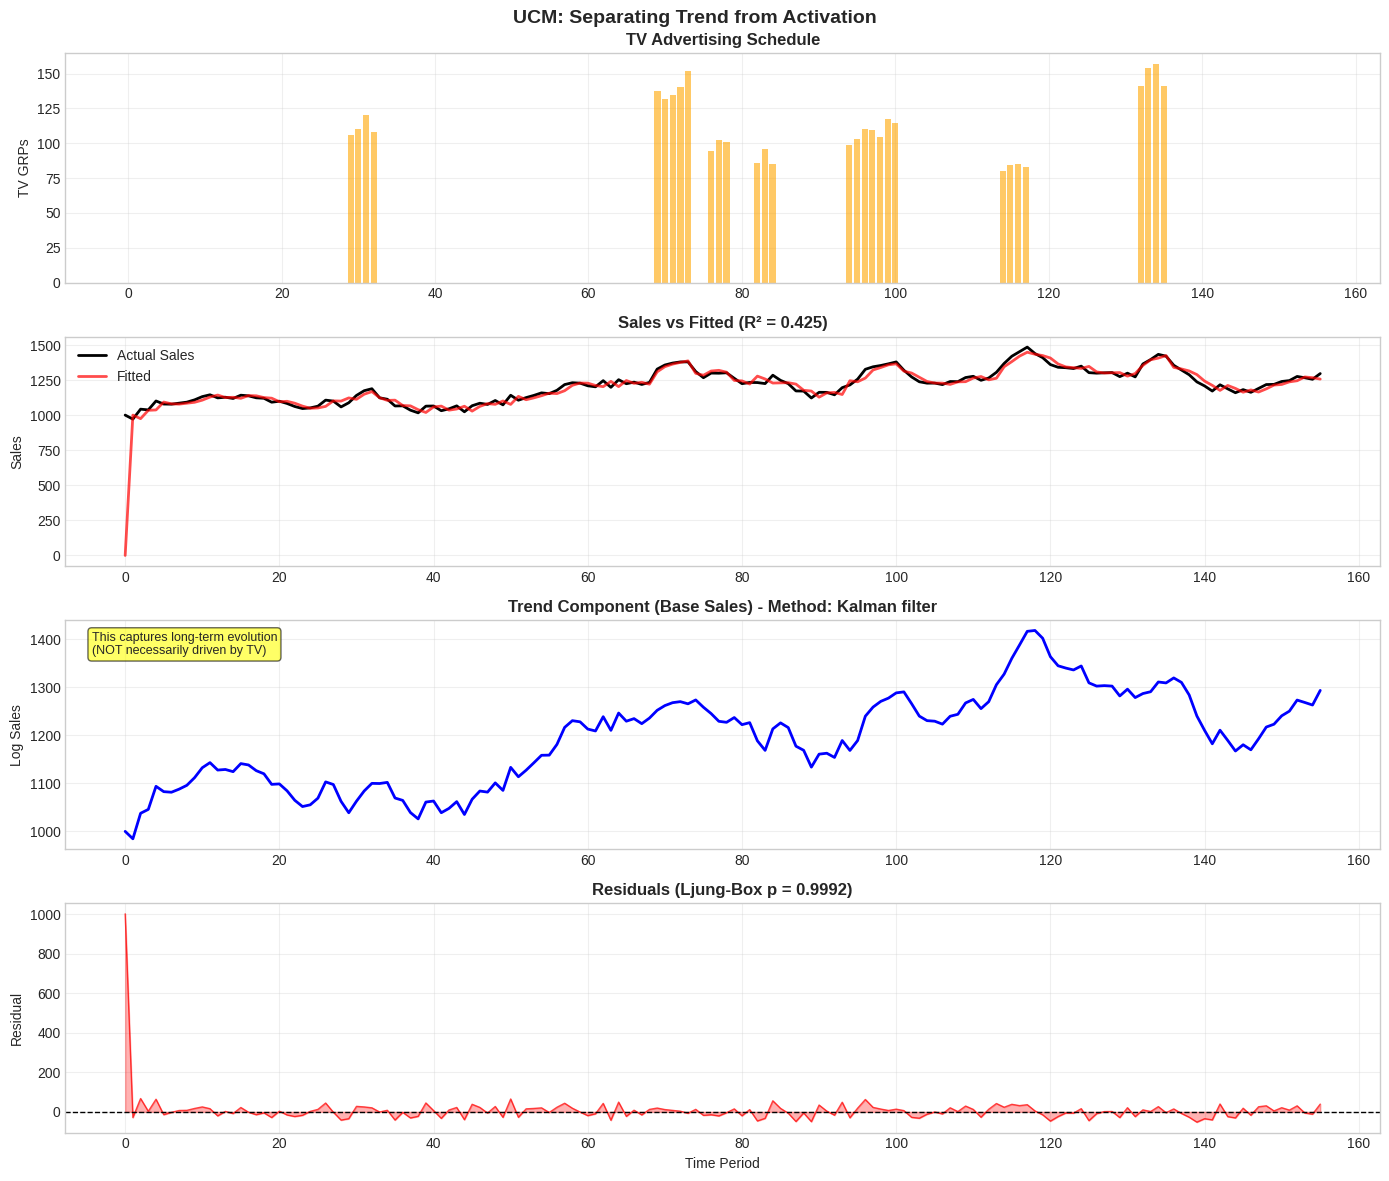


📊 Key insight:
   • Trend (Panel 3) shows base sales evolution
   • UCM doesn't force it to correlate with TV
   • More realistic than dual-adstock

⚠️  BUT: Still sensitive to model choices!


In [7]:
# Plot UCM decomposition
fig = plot_ucm_decomposition(
    sales=data['sales'].values,
    tv=data['tv'].values,
    ucm_results=ucm_results,
    title="UCM: Separating Trend from Activation"
)
plt.show()

print("\n📊 Key insight:")
print("   • Trend (Panel 3) shows base sales evolution")
print("   • UCM doesn't force it to correlate with TV")
print("   • More realistic than dual-adstock")
print("\n⚠️  BUT: Still sensitive to model choices!")

## Part 3: Alternative 2 - Vector Autoregression (VAR)

**What it does:** Tests if effects truly persist using Impulse Response Functions.

**Limitations:**
- Data hungry (loses degrees of freedom)
- Sensitive to lag length
- IRFs can be unstable

**Verdict:** Theoretically sound, provides proper inference, but complex.

In [8]:
print("="*70)
print("FITTING VECTOR AUTOREGRESSION (VAR)")
print("="*70)

var_results = fit_var_model(
    sales=data['sales'].values,
    tv=data['tv'].values,
    maxlags=4
)

print(f"\nSeries differenced: {var_results['is_differenced']}")
print(f"Sales ADF p-value: {var_results['sales_adf_pvalue']:.4f}")
print(f"TV ADF p-value: {var_results['tv_adf_pvalue']:.4f}")

long_term_effect = var_results['cumulative_irf'][-1]
print(f"\nCumulative long-term effect: {long_term_effect:.4f}")

if abs(long_term_effect) < 0.01:
    print("\n✓ Correctly identifies effects decay to zero")
    print("  (No persistent brand-building)")
else:
    print("\n⚠️  Suggests some persistence")
    print("   (But check confidence bands!)")

FITTING VECTOR AUTOREGRESSION (VAR)
⚠️  Non-stationary series detected:
   Sales ADF p-value: 0.0868
   TV ADF p-value: 0.0000
   Differencing the data...

Series differenced: True
Sales ADF p-value: 0.0868
TV ADF p-value: 0.0000

Cumulative long-term effect: 0.4162

⚠️  Suggests some persistence
   (But check confidence bands!)


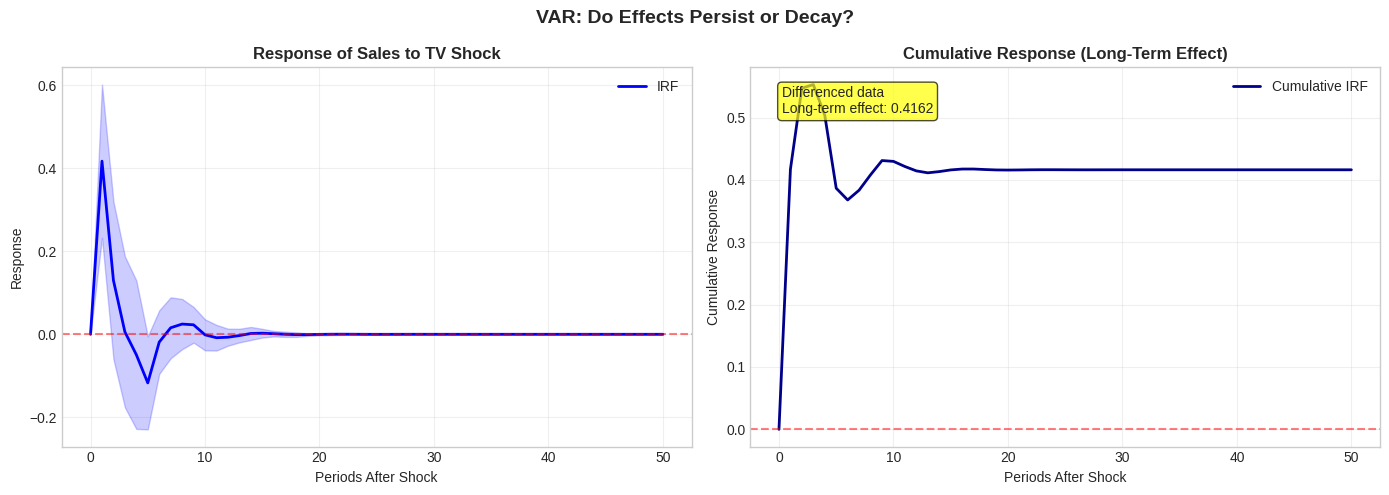


📊 Interpretation:
   • Left panel: Immediate response, then decay
   • Right panel: Cumulative effect over time
   • If cumulative stays near zero: activation only
   • If cumulative persists: brand-building present


In [9]:
# Plot IRFs
fig = plot_var_irf(
    var_results=var_results,
    title="VAR: Do Effects Persist or Decay?"
)
plt.show()

print("\n📊 Interpretation:")
print("   • Left panel: Immediate response, then decay")
print("   • Right panel: Cumulative effect over time")
print("   • If cumulative stays near zero: activation only")
print("   • If cumulative persists: brand-building present")

## Part 4: Alternative 3 - Combined UCM + VAR (Conceptual)

**What it does:** UCM extracts trend, then VAR models trend using brand metrics.

**Limitations:**
- Requires brand survey data (expensive, often unavailable)
- Very complex to implement
- Two-step estimation compounds uncertainty
- Few have done this successfully

**Verdict:** Most theoretically sound, but borderline impractical.

In [10]:
# Combined approach (conceptual)
combined_results = fit_combined_approach(
    sales=data['sales'].values,
    tv=data['tv'].values,
    brand_metric=None,  # We don't have brand survey data
    short_retention=0.30,
    maxlags=4
)

print("\n💡 In practice, you would need:")
print("   1. Regular brand tracking surveys ($$$$)")
print("   2. Tests for cointegration")
print("   3. Structural VAR identification")
print("   4. Extensive validation")
print("\n⚠️  Very few companies have all this in place.")

COMBINED UCM + VAR APPROACH (CONCEPTUAL)

⚠️  WARNING: This is a conceptual implementation.
   Requires:
   1. Brand survey data (awareness, consideration, preference)
   2. Cointegration between base sales and brand metrics
   3. Sufficient data for two-step estimation

Step 1: Extracting base sales trend with UCM...
   ✓ Trend extracted (method: Kalman filter)

Step 2: Modeling trend with VAR...
   ⚠️  No brand metric provided. Using trend and TV only.
      (This defeats the purpose of the combined approach!)
   Trend is non-stationary (p=0.2195)
   Should test for cointegration with brand metrics...
   (Not implemented in this conceptual version)
   ✓ VAR fitted with 4 lags

CAVEAT: This combined approach is HIGHLY EXPERIMENTAL
In practice, you would need:
1. Regular brand tracking surveys (expensive)
2. Johansen cointegration tests
3. Structural identification of the VAR
4. Validation against holdout data

Very few organizations have successfully implemented this.

💡 In practice, 

## Part 5: The Brutal Truth

### What We've Shown:

1. **Dual-adstock is broken** (DW < 1.5 proves spurious regression)
2. **UCM is better** (but sensitive to specification)
3. **VAR is sound** (but data-hungry and complex)
4. **Combined is best** (but impractical for most)

### The Real Question:

**Can we actually measure long-term effects?**

**Honest answer: Barely, and with huge uncertainty.**

### Why This is So Hard:

- Signal-to-noise ratio is terrible
- All channels are correlated
- Many confounders over 6-18 months
- Data requirements are unrealistic

### What Practitioners Should Do:

1. **Don't use dual-adstock with λ > 0.95**
2. **Always check diagnostics** (DW, Ljung-Box)
3. **Use shorter retention** (λ = 0.5-0.8 for "medium-term")
4. **Triangulate evidence** (Mid funnel + surveys + experiments)
5. **Report uncertainty honestly** (ranges, not point estimates)
6. **Be skeptical of vendor claims**

### Questions to Ask Vendors:

- What's your Durbin-Watson statistic?
- What retention rate are you using?
- Can I see residual diagnostics?
- What happens if you use λ = 0.5 instead of 0.99?

If they can't answer → 🚩🚩🚩

---

## Part 6: Apply to Your Own Data

Now check YOUR models:

In [11]:
# Load your data
# your_sales = pd.read_csv('your_sales.csv')['sales'].values
# your_tv = pd.read_csv('your_tv.csv')['tv'].values

# Quick check
# results = check_dual_adstock_diagnostics(your_sales, your_tv)

# Full diagnostics
# results = fit_dual_adstock_model(your_sales, your_tv)
# fig = plot_diagnostic_dashboard(your_sales, your_tv, results)

# Try alternatives
# ucm_results = fit_ucm_model(your_sales, your_tv)
# var_results = fit_var_model(your_sales, your_tv)

print("Uncomment the code above and replace with your data paths.")

Uncomment the code above and replace with your data paths.


## Final Thoughts

**From Charlie:**

Long-term effects are really hard to measure. This notebook doesn't claim to solve the problem. What it does is:

1. Show you one approach that's definitely wrong
2. Show you some approaches that are less wrong
3. Give you tools to evaluate claims critically

**Anyone who tells you they've "solved" long-term measurement is either naive or selling something.**

But we keep trying, stay honest about uncertainty, and don't oversell our confidence.

Good luck. 🍀

---

**Reference:**  
Cain, P.M. (2025). "Long-term advertising effects: The Adstock illusion."  
*Applied Marketing Analytics*, 11(1), 23-42.